# MNIST Digit Classification Project - Python Code

Steve Desilets

October 8, 2023

## 1) Introduction

For this project, we will be constructing models capable of classifying images of hand-drawn digits as the appropriate number (from 0 throuh 9).  To achieve this objective, we will construct several artificial neural network (ANN) models, an ANN model that leverages input data derived from principal components analysis (PCA), and a Random Forest Classifier model. For each of these models, we'll examine performance metrics as well as the key features that the models extracted during the training process.

## 2) Importing Data, Conducting Exploratory Data Analysis, and Cleaning Data

### 2.1) Notebook Set-Up and Data Importation

First, let's download the necessary packages.

In [2]:
import datetime
from packaging import version
from collections import Counter
import numpy as np
import pandas as pd

import matplotlib as mpl  # EA
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.datasets import mnist
import tensorflow.keras.backend as k

In [3]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

In [4]:
tf.compat.v1.disable_eager_execution() # neccessary for K.gradient to work in TensorFlow 2.x

In [5]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.12.0


Now let's mount to the Google Colab environment.

In [ ]:
#from google.colab import drive
#drive.mount('/content/gdrive')

Let's define functions that will be useful throughout the model development and assessment process.

In [6]:
def print_validation_report(test_labels, predictions):
    print("Classification Report")
    print(classification_report(test_labels, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(test_labels, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(test_labels, predictions))))

def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(16,12))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

def plot_history(history):
  losses = history.history['loss']
  accs = history.history['accuracy']
  val_losses = history.history['val_loss']
  val_accs = history.history['val_accuracy']
  epochs = len(losses)

  plt.figure(figsize=(16, 4))
  for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
  plt.show()

def plot_digits(instances, pos, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    pos.imshow(image, cmap = 'binary', **options)
    pos.axis("off")

def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = 'hot',
               interpolation="nearest")
    plt.axis("off")

Let's load the MNIST dataset into this Python notebook.

The MNIST dataset of handwritten digits has a training set of 60,000 images, and a test set of 10,000 images. It comes prepackaged as part of `tf.Keras`. We will load this dataset and the corresponding labels as Numpy arrays.

* Tuples of Numpy arrays: `(x_train, y_train)`, `(x_test, y_test)`
* `x_train`, `x_test`: uint8 arrays of grayscale image data with shapes (num_samples, 28, 28).
* `y_train`, `y_test`: uint8 arrays of digit labels (integers in range 0-9)

In [7]:
(x_train, y_train), (x_test, y_test)= tf.keras.datasets.mnist.load_data()

### 2.2) Exploratory Data Analysis

Let's perform exploratory data analysis on the imported MNIST data.

Let's examine the shape of our datasets.

In [8]:
print('x_train:\t{}'.format(x_train.shape))
print('y_train:\t{}'.format(y_train.shape))
print('x_test:\t\t{}'.format(x_test.shape))
print('y_test:\t\t{}'.format(y_test.shape))

x_train:	(60000, 28, 28)
y_train:	(60000,)
x_test:		(10000, 28, 28)
y_test:		(10000,)


Let's print the first 10 labels in our training and test datasets.

In [9]:
print("First ten labels training dataset:\n {}\n".format(y_train[0:10]))

First ten labels training dataset:
 [5 0 4 1 9 2 1 3 1 4]



In [10]:
print("First ten labels training dataset:\n {}\n".format(y_test[0:10]))

First ten labels training dataset:
 [7 2 1 0 4 1 4 9 5 9]



Let's examine the distribution of label values in our training and test datasets.

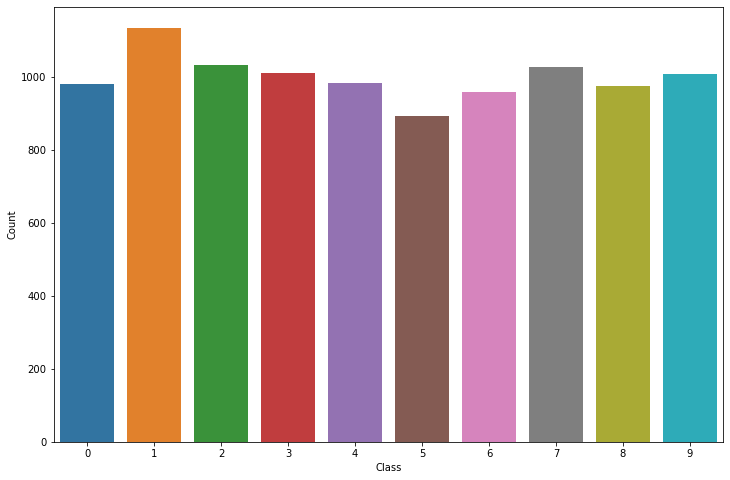

In [11]:
plt.figure(figsize = (12 ,8))
items = [{'Class': x, 'Count': y} for x, y in Counter(y_test).items()]
distribution = pd.DataFrame(items).sort_values(['Class'])
sns.barplot(x=distribution.Class, y=distribution.Count);

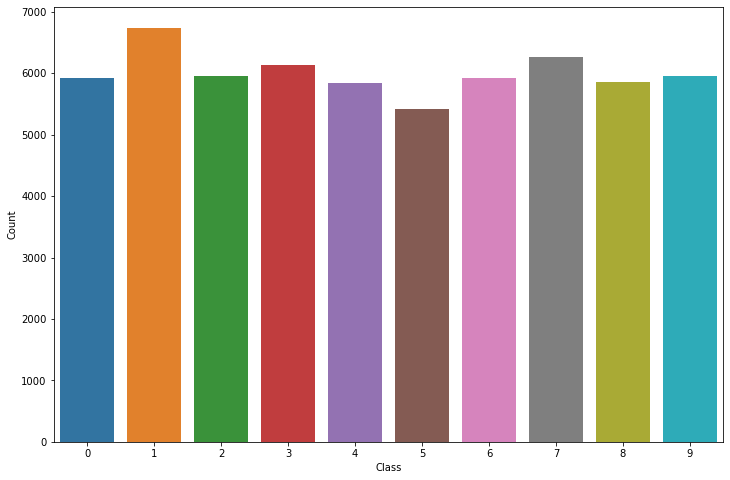

In [12]:
plt.figure(figsize = (12 ,8))
items = [{'Class': x, 'Count': y} for x, y in Counter(y_train).items()]
distribution = pd.DataFrame(items).sort_values(['Class'])
sns.barplot(x=distribution.Class, y=distribution.Count);

In [13]:
Counter(y_train).most_common()

[(1, 6742),
 (7, 6265),
 (3, 6131),
 (2, 5958),
 (9, 5949),
 (0, 5923),
 (6, 5918),
 (8, 5851),
 (4, 5842),
 (5, 5421)]

In [14]:
Counter(y_test).most_common()

[(1, 1135),
 (2, 1032),
 (7, 1028),
 (3, 1010),
 (9, 1009),
 (4, 982),
 (0, 980),
 (8, 974),
 (6, 958),
 (5, 892)]

Let's examine the first fifty images in the training and test datasets.

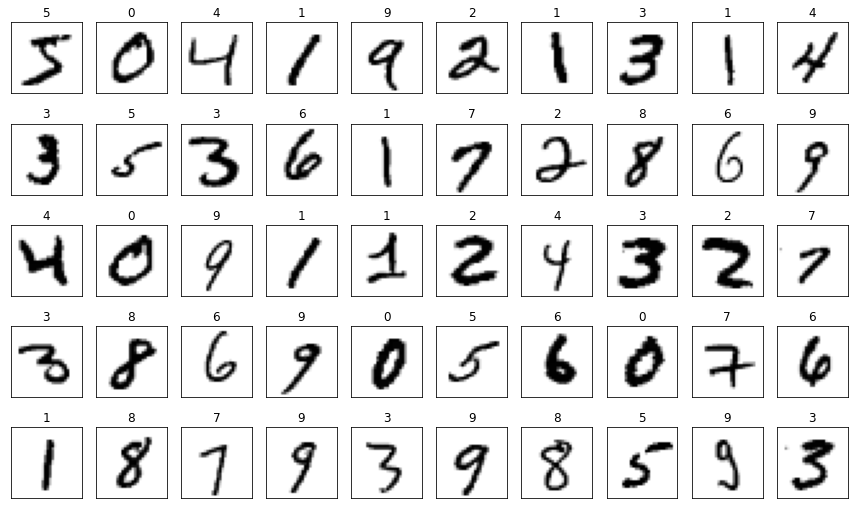

In [15]:
fig = plt.figure(figsize = (15, 9))

for i in range(50):
    plt.subplot(5, 10, 1+i)
    plt.title(y_train[i])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_train[i].reshape(28,28), cmap='binary')

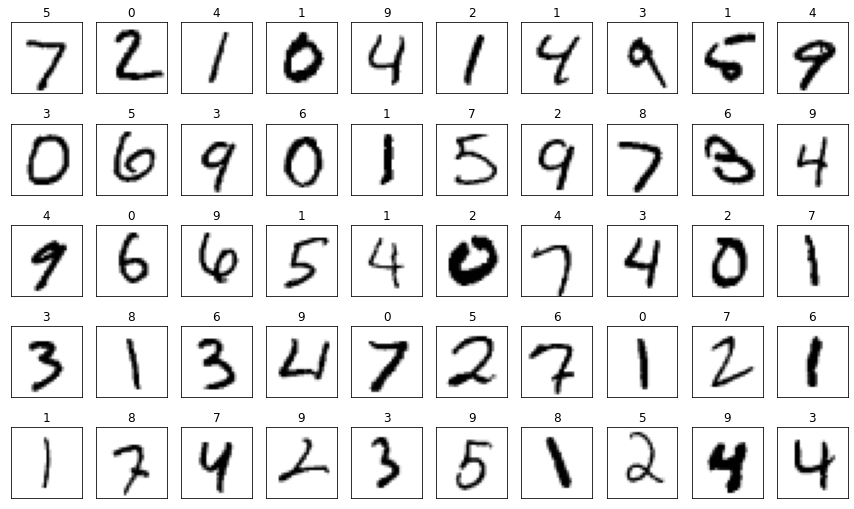

In [16]:
fig = plt.figure(figsize = (15, 9))

for i in range(50):
    plt.subplot(5, 10, 1+i)
    plt.title(y_train[i])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[i].reshape(28,28), cmap='binary')

### 2.3) Data Cleaning and Pre-Processing

* Before we build our model, we need to prepare the data into the shape the network expected
* More specifically, we will convert the labels (integers 0 to 9) to 1D numpy arrays of shape (10,) with elements 0s and 1s.
* We also reshape the images from 2D arrays of shape (28,28) to 1D *float32* arrays of shape (784,) and then rescale their elements to values between 0 and 1.

##### Let's apply one-hot coding to the labels.

We will change the way the labels are represented from numbers (0 to 9) to vectors (1D arrays) of shape (10, ) with all the elements set to 0 except the one which the label belongs to - which will be set to 1. For example:


| original label | one-hot encoded label |
|------|------|
| 5 | [0 0 0 0 0 1 0 0 0 0] |
| 7 | [0 0 0 0 0 0 0 1 0 0] |
| 1 | [0 1 0 0 0 0 0 0 0 0] |

In [17]:
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)

print("First ten entries of y_train:\n {}\n".format(y_train[0:10]))
print("First ten rows of one-hot y_train:\n {}".format(y_train_encoded[0:10,]))

print("First ten entries of y_test:\n {}\n".format(y_train[0:10]))
print("First ten rows of one-hot y_test:\n {}".format(y_train_encoded[0:10,]))

First ten entries of y_train:
 [5 0 4 1 9 2 1 3 1 4]

First ten rows of one-hot y_train:
 [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]
First ten entries of y_test:
 [5 0 4 1 9 2 1 3 1 4]

First ten rows of one-hot y_test:
 [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


In [18]:
print('y_train_encoded shape: ', y_train_encoded.shape)
print('y_test_encoded shape: ', y_test_encoded.shape)

y_train_encoded shape:  (60000, 10)
y_test_encoded shape:  (10000, 10)


##### Reshape the images to 1D arrays

Reshape the images from shape (28, 28) 2D arrays to shape (784, ) vectors (1D arrays).

In [19]:
# Before reshape:
print('x_train:\t{}'.format(x_train.shape))
print('x_test:\t\t{}'.format(x_test.shape))

x_train:	(60000, 28, 28)
x_test:		(10000, 28, 28)


In [20]:
np.set_printoptions(linewidth=np.inf)
print("{}".format(x_train[2020]))

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0 167 208  19   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  13 235 254  99   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  74 254 234   4   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0 154 254 145   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0 224 254  92   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0  51 245 211  13   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   2 169 254 101   0   0   0   0   0   

In [21]:
# Reshape the images:
x_train_reshaped = np.reshape(x_train, (60000, 784))
x_test_reshaped = np.reshape(x_test, (10000, 784))

# After reshape:
print('x_train_reshaped shape: ', x_train_reshaped.shape)
print('x_test_reshaped shape: ', x_test_reshaped.shape)

x_train_reshaped shape:  (60000, 784)
x_test_reshaped shape:  (10000, 784)


1. Each element in an image is a pixel value
2. Pixel values range from 0 to 255
3. 0 = White
4. 255 = Black

Let's review thew unique values using the set from the first image in the training dataset.

In [22]:
print(set(x_train_reshaped[0]))

{0, 1, 2, 3, 9, 11, 14, 16, 18, 23, 24, 25, 26, 27, 30, 35, 36, 39, 43, 45, 46, 49, 55, 56, 64, 66, 70, 78, 80, 81, 82, 90, 93, 94, 107, 108, 114, 119, 126, 127, 130, 132, 133, 135, 136, 139, 148, 150, 154, 156, 160, 166, 170, 171, 172, 175, 182, 183, 186, 187, 190, 195, 198, 201, 205, 207, 212, 213, 219, 221, 225, 226, 229, 238, 240, 241, 242, 244, 247, 249, 250, 251, 252, 253, 255}


##### Rescale the elements of the reshaped images

Let's rescale the elements of the x_train_reshaped and x_test_reshaped datasets to be between 0 and 1. 

In [23]:
x_train_norm = x_train_reshaped.astype('float32') / 255
x_test_norm = x_test_reshaped.astype('float32') / 255

In [24]:
# Take a look at the first reshaped and normalized training image:
print(set(x_train_norm[0]))
print(set(x_test_norm[0]))

{0.0, 0.011764706, 0.53333336, 0.07058824, 0.49411765, 0.6862745, 0.101960786, 0.6509804, 1.0, 0.96862745, 0.49803922, 0.11764706, 0.14117648, 0.36862746, 0.6039216, 0.6666667, 0.043137256, 0.05490196, 0.03529412, 0.85882354, 0.7764706, 0.7137255, 0.94509804, 0.3137255, 0.6117647, 0.41960785, 0.25882354, 0.32156864, 0.21960784, 0.8039216, 0.8666667, 0.8980392, 0.7882353, 0.52156866, 0.18039216, 0.30588236, 0.44705883, 0.3529412, 0.15294118, 0.6745098, 0.88235295, 0.99215686, 0.9490196, 0.7647059, 0.2509804, 0.19215687, 0.93333334, 0.9843137, 0.74509805, 0.7294118, 0.5882353, 0.50980395, 0.8862745, 0.105882354, 0.09019608, 0.16862746, 0.13725491, 0.21568628, 0.46666667, 0.3647059, 0.27450982, 0.8352941, 0.7176471, 0.5803922, 0.8117647, 0.9764706, 0.98039216, 0.73333335, 0.42352942, 0.003921569, 0.54509807, 0.67058825, 0.5294118, 0.007843138, 0.31764707, 0.0627451, 0.09411765, 0.627451, 0.9411765, 0.9882353, 0.95686275, 0.83137256, 0.5176471, 0.09803922, 0.1764706}
{0.0, 0.32941177, 0.59

## 3) Experiment 1 - ANN with 1 Hidden Layer with 1 Node

### 3.1) Construct Model

Now that we've finished preprocessing our MNIST image data, let's construct our first artificial neural network to classify images as integers.

In [25]:
k.clear_session()

model = Sequential([
    Dense(input_shape=[784], units=1, activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(name = "output_layer", units = 10, activation = tf.nn.softmax)
])

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 785       
                                                                 
 output_layer (Dense)        (None, 10)                20        
                                                                 
Total params: 805
Trainable params: 805
Non-trainable params: 0
_________________________________________________________________


In [27]:
model.compile(optimizer='rmsprop',
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

In [28]:
#tf.keras.model.fit
#https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit

#tf.keras.callbacks.EarlyStopping
#https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping


history = model.fit(
    x_train_norm
    ,y_train_encoded
    ,epochs = 200
    ,validation_split=(5000/60000)
    ,callbacks=[tf.keras.callbacks.ModelCheckpoint("DNN_model.h5",save_best_only=True,save_weights_only=False)
                ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
    )

Train on 55000 samples, validate on 5000 samples
Epoch 1/200
54016/55000 [============================>.] - ETA: 0s - loss: 1.9729 - accuracy: 0.1990

C:\Users\steve\anaconda3\lib\site-packages\keras\engine\training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


55000/55000 [==============================] - 2s 41us/sample - loss: 1.9710 - accuracy: 0.1995 - val_loss: 1.8240 - val_accuracy: 0.2272
Epoch 2/200
55000/55000 [==============================] - 2s 34us/sample - loss: 1.8226 - accuracy: 0.2230 - val_loss: 1.7729 - val_accuracy: 0.2440
Epoch 3/200
55000/55000 [==============================] - 2s 45us/sample - loss: 1.7863 - accuracy: 0.2505 - val_loss: 1.7355 - val_accuracy: 0.2830
Epoch 4/200
55000/55000 [==============================] - 2s 40us/sample - loss: 1.7419 - accuracy: 0.2867 - val_loss: 1.6806 - val_accuracy: 0.3164
Epoch 5/200
55000/55000 [==============================] - 2s 35us/sample - loss: 1.6946 - accuracy: 0.3025 - val_loss: 1.6368 - val_accuracy: 0.3168
Epoch 6/200
55000/55000 [==============================] - 2s 37us/sample - loss: 1.6681 - accuracy: 0.3080 - val_loss: 1.6177 - val_accuracy: 0.3200
Epoch 7/200
55000/55000 [==============================] - 2s 33us/sample - loss: 1.6537 - accuracy: 0.3130 - va

### 3.2) Evaluate Model Performance on Testing Dataset

Now that we've fit our model, let's apply the model to the test dataset and subsequently evaluate its performance.

In [29]:
model = tf.keras.models.load_model("DNN_model.h5")
print(f"Test acc: {model.evaluate(x_test_norm, y_test_encoded)[1]:.3f}")

Test acc: 0.383


In [30]:
# loss, accuracy = model.evaluate(x_test_norm, y_test_encoded)
# print('test set accuracy: ', accuracy * 100)

In [31]:
preds = model.predict(x_test_norm)
print('shape of preds: ', preds.shape)

C:\Users\steve\anaconda3\lib\site-packages\keras\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


shape of preds:  (10000, 10)


As part of our model evaluation, let's look at the first 25 images by plotting the test set images along with their predicted and actual labels to understand how the trained model actually performed on specific example images.

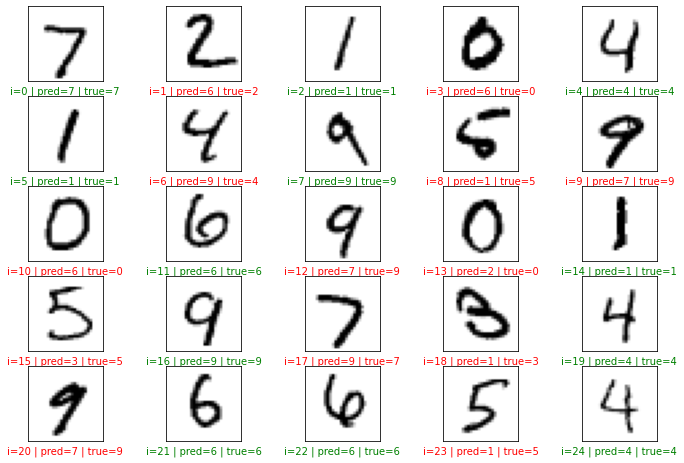

In [32]:
plt.figure(figsize = (12, 8))

start_index = 0

for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    pred = np.argmax(preds[start_index + i])
    actual = np.argmax(y_test_encoded[start_index + i])
    col = 'g'
    if pred != actual:
        col = 'r'
    plt.xlabel('i={} | pred={} | true={}'.format(start_index + i, pred, actual), color = col)
    plt.imshow(x_test[start_index + i], cmap='binary')
plt.show()

Let's use `Matplotlib` to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

In [33]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [34]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

In [35]:
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
9,1.630,0.358,1.575,0.392
10,1.620,0.387,1.567,0.405
11,1.604,0.397,1.545,0.415
12,1.592,0.395,1.536,0.411
13,1.584,0.394,1.532,0.404


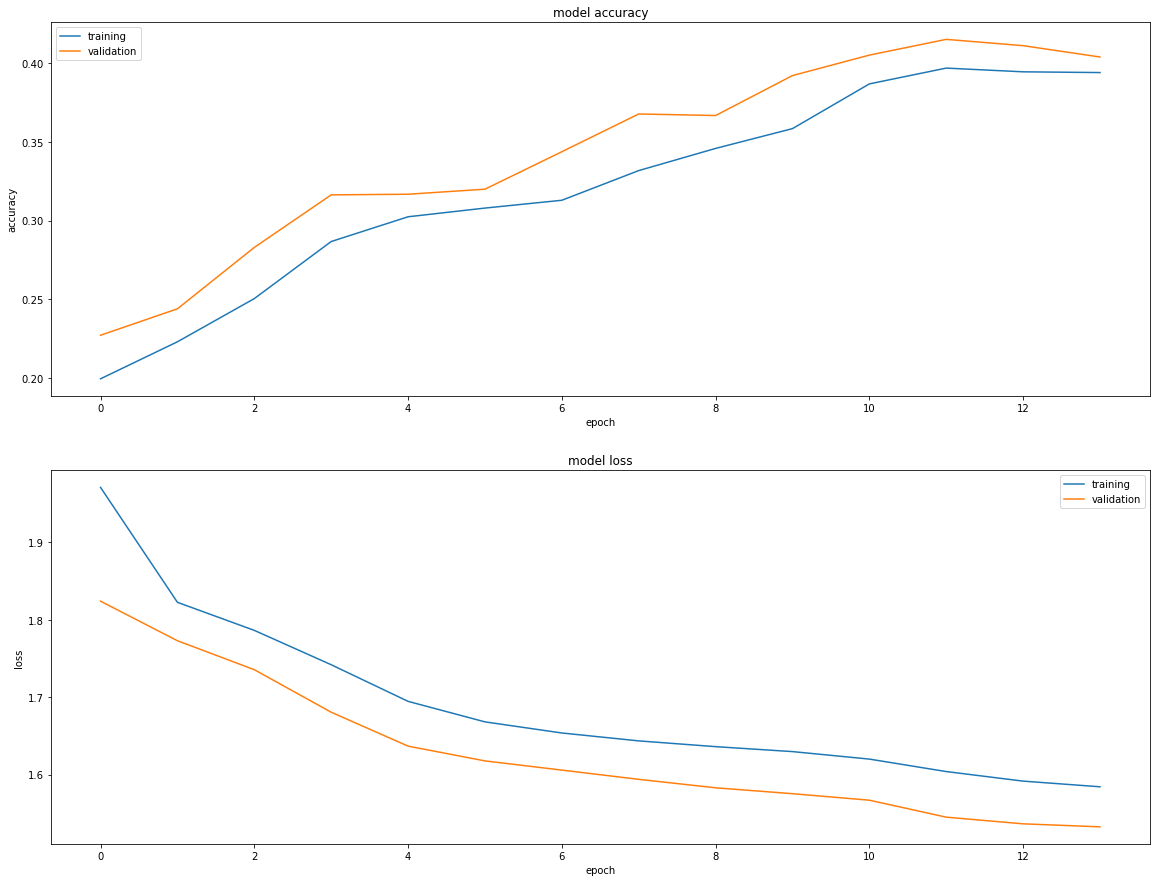

In [36]:
def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

Let's examine precision and recall performance metrics for each of the prediction classes.

In [37]:
pred1= model.predict(x_test_norm)
pred1=np.argmax(pred1, axis=1)

In [38]:
print_validation_report(y_test, pred1)

Classification Report
              precision    recall  f1-score   support

           0       0.18      0.02      0.04       980
           1       0.40      0.86      0.54      1135
           2       0.24      0.07      0.11      1032
           3       0.27      0.35      0.30      1010
           4       0.44      0.43      0.44       982
           5       0.00      0.00      0.00       892
           6       0.33      0.90      0.49       958
           7       0.62      0.61      0.62      1028
           8       0.26      0.04      0.06       974
           9       0.40      0.45      0.43      1009

    accuracy                           0.38     10000
   macro avg       0.31      0.37      0.30     10000
weighted avg       0.32      0.38      0.31     10000

Accuracy Score: 0.3831
Root Mean Square Error: 3.3357907608241857


C:\Users\steve\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\steve\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\steve\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Let's create a table that visualizes the model output for each of the first 20 images. These outputs can be thought of as the model's expression of the probability that each image corresponds to each digit class.

In [39]:
# Get the predicted classes:
# pred_classes = model.predict_classes(x_train_norm)# give deprecation warning
pred_classes = np.argmax(model.predict(x_test_norm), axis=-1)
pred_classes;

<div class="alert alert-block alert-info">
    <b>Correlation matrix that measures the linear relationships</b><br>
    https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html
    </div>

In [40]:
conf_mx = tf.math.confusion_matrix(y_test, pred_classes)
conf_mx;

In [41]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)
df = pd.DataFrame(preds[0:20], columns = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
df.style.format("{:.2%}").background_gradient(cmap=cm)

,0,1,2,3,4,5,6,7,8,9
0,0.00%,0.00%,0.00%,0.18%,6.95%,0.12%,0.00%,60.09%,0.12%,32.55%
1,27.85%,9.33%,21.94%,1.68%,0.19%,1.65%,35.37%,0.01%,1.95%,0.03%
2,6.39%,27.22%,13.02%,15.44%,4.45%,14.17%,1.40%,0.35%,16.27%,1.30%
3,27.85%,9.33%,21.94%,1.68%,0.19%,1.65%,35.37%,0.01%,1.95%,0.03%
4,0.04%,6.24%,0.30%,18.70%,21.64%,15.56%,0.00%,6.46%,17.15%,13.92%
5,4.17%,25.90%,9.79%,17.41%,5.78%,15.81%,0.70%,0.52%,18.08%,1.83%
6,0.00%,0.33%,0.00%,5.25%,24.35%,3.96%,0.00%,27.55%,4.19%,34.37%
7,0.00%,1.01%,0.01%,9.14%,26.70%,7.13%,0.00%,19.38%,7.64%,29.00%
8,15.21%,25.42%,21.85%,9.46%,1.92%,8.90%,6.36%,0.11%,10.32%,0.46%
9,0.00%,0.00%,0.00%,0.27%,8.24%,0.18%,0.00%,57.22%,0.18%,33.91%


Let's create a confusion matrix that visualizes the model's performance on the testing data.

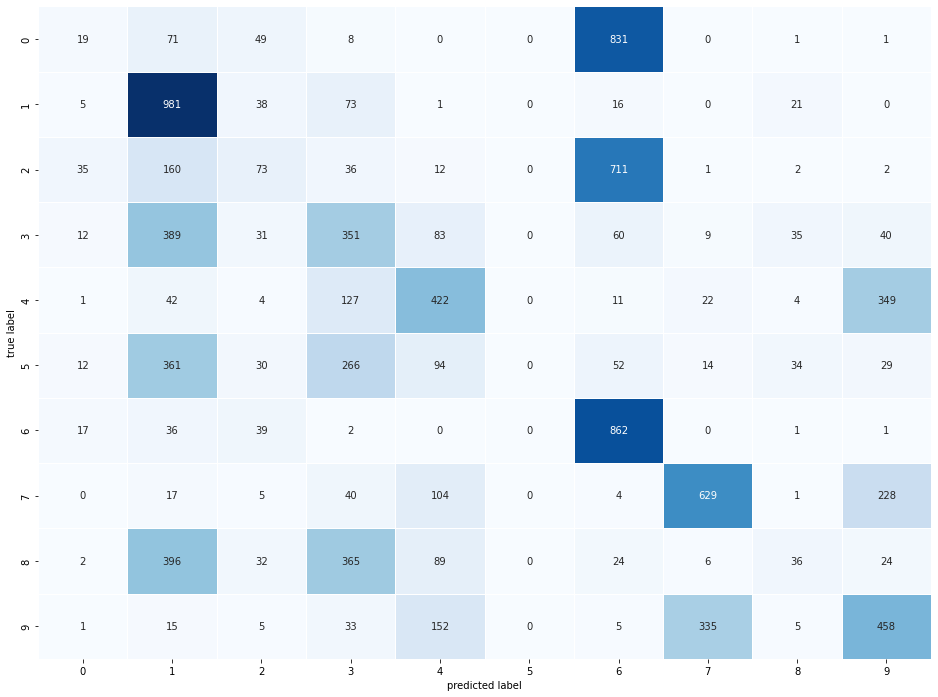

In [42]:
plot_confusion_matrix(y_test,pred_classes)

It looks like 831 zeroes were misclassified as sixes (and 17 sixes were misclassified as zeroes). We display some of these misclassfications along with an examination of zeroes and sixes that were correctly identified.



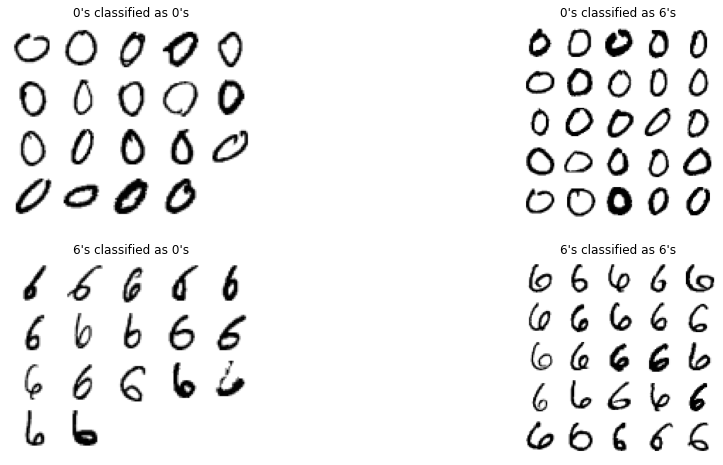

In [43]:
cl_a, cl_b = 0, 6
X_aa = x_test_norm[(y_test == cl_a) & (pred_classes == cl_a)]
X_ab = x_test_norm[(y_test == cl_a) & (pred_classes == cl_b)]
X_ba = x_test_norm[(y_test == cl_b) & (pred_classes == cl_a)]
X_bb = x_test_norm[(y_test == cl_b) & (pred_classes == cl_b)]

plt.figure(figsize=(16,8))

p1 = plt.subplot(221)
p2 = plt.subplot(222)
p3 = plt.subplot(223)
p4 = plt.subplot(224)

plot_digits(X_aa[:25], p1, images_per_row=5);
plot_digits(X_ab[:25], p2, images_per_row=5);
plot_digits(X_ba[:25], p3, images_per_row=5);
plot_digits(X_bb[:25], p4, images_per_row=5);


p1.set_title(f"{cl_a}'s classified as {cl_a}'s")
p2.set_title(f"{cl_a}'s classified as {cl_b}'s")
p3.set_title(f"{cl_b}'s classified as {cl_a}'s")
p4.set_title(f"{cl_b}'s classified as {cl_b}'s")

# plt.savefig("error_analysis_digits_plot_EXP1_valid")

plt.show()

### 3.3) Examine Model Activation Values

To get the activation values of the hidden nodes, we need to create a new model, `activation_model`, that takes the same input as our current model but outputs the activation value of the hidden layer, i.e. of the hidden node. Then use the `predict` function to get the activation values.

In [44]:
# Extracts the outputs of the 2 layers:
layer_outputs = [layer.output for layer in model.layers]

# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

print(f"There are {len(layer_outputs)} layers")
layer_outputs; # description of the layers

There are 2 layers


In [45]:
# Get the outputs of all the hidden nodes for each of the 60000 training images
activations = activation_model.predict(x_train_norm)
hidden_layer_activation = activations[0]
output_layer_activations = activations[1]
hidden_layer_activation.shape   #  each of the 128 hidden nodes has one activation value per training image

C:\Users\steve\anaconda3\lib\site-packages\keras\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


(60000, 1)

In [46]:
output_layer_activations.shape

(60000, 10)

In [47]:
print(f"The maximum activation value of the hidden nodes in the hidden layer is \
{hidden_layer_activation.max()}")

The maximum activation value of the hidden nodes in the hidden layer is 10.495893478393555


In [48]:
# Some stats about the output layer as an aside...
np.set_printoptions(suppress = True)  # display probabilities as decimals and NOT in scientific notation
ouput_layer_activation = activations[1]
print(f"The output node has shape {ouput_layer_activation.shape}")
print(f"The output for the first image are {ouput_layer_activation[0].round(4)}")
print(f"The sum of the probabilities is (approximately) {ouput_layer_activation[0].sum()}")

The output node has shape (60000, 10)
The output for the first image are [0.104 0.273 0.177 0.125 0.03  0.116 0.032 0.002 0.134 0.008]
The sum of the probabilities is (approximately) 0.9999999403953552


In [49]:
#Get the dataframe of all the node values
activation_data = {'actual_class':y_train}
for k in range(0,1):
    activation_data[f"act_val_{k}"] = hidden_layer_activation[:,k]

activation_df = pd.DataFrame(activation_data)
activation_df.head(15).round(3).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
actual_class,5.00,0.0,4.000,1.000,9.000,2.000,1.00,3.000,1.00,4.000,3.000,5.000,3.000,6.0,1.000
act_val_0,0.79,0.0,3.088,0.868,4.732,0.914,1.13,1.358,0.95,2.957,2.012,1.035,1.207,0.0,0.736


Let's visualize these activiation values via boxplots.

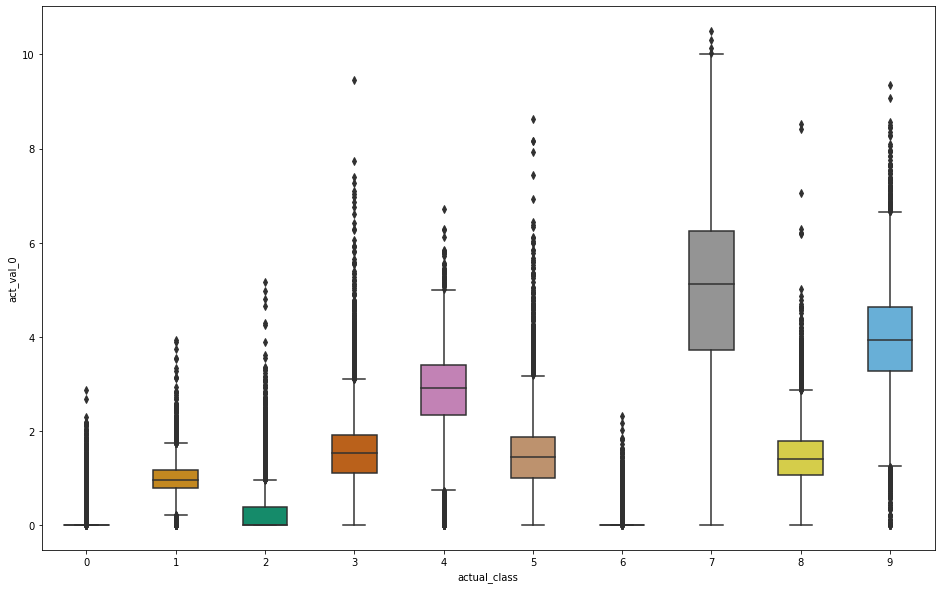

In [50]:
# To see how closely the hidden node activation values correlate with the class labels
# Let us use seaborn for the boxplots this time.
plt.figure(figsize=(16,10))
bplot = sns.boxplot(y='act_val_0', x='actual_class',
                 data=activation_df[['act_val_0','actual_class']],
                 width=0.5,
                 palette="colorblind")

In [51]:
activation_df.groupby("actual_class")["act_val_0"].apply(lambda x: [round(min(x.tolist()),2),
 round(max(x.tolist()),2)]).reset_index().rename(columns={"act_val_0": "range_of_act_values"})

,actual_class,range_of_act_values
0,0,"[0.0, 2.88]"
1,1,"[0.0, 3.94]"
2,2,"[0.0, 5.16]"
3,3,"[0.0, 9.45]"
4,4,"[0.0, 6.72]"
5,5,"[0.0, 8.64]"
6,6,"[0.0, 2.33]"
7,7,"[0.0, 10.5]"
8,8,"[0.0, 8.52]"
9,9,"[0.0, 9.36]"


Let's get activation values of the pixel values.

We can create a dataframe with the pixel values and class labels

In [52]:
#Get the dataframe of all the pixel values
pixel_data = {'actual_class':y_train}
for k in range(0,784):
    pixel_data[f"pix_val_{k}"] = x_train_norm[:,k]
pixel_df = pd.DataFrame(pixel_data)
pixel_df.head(15).round(3).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
actual_class,5.0,0.0,4.0,1.0,9.0,2.0,1.0,3.0,1.0,4.0,3.0,5.0,3.0,6.0,1.0
pix_val_0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
pix_val_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
pix_val_2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
pix_val_3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
pix_val_779,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
pix_val_780,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
pix_val_781,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
pix_val_782,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
pixel_df.pix_val_77.value_counts()

0.000000    59720
1.000000       25
0.996078       13
0.992157        9
0.050980        6
            ...  
0.894118        1
0.690196        1
0.725490        1
0.517647        1
0.819608        1
Name: pix_val_77, Length: 150, dtype: int64

In [54]:
pixel_df.pix_val_78.value_counts()

0.000000    59862
1.000000        6
0.960784        4
0.992157        4
0.141176        4
            ...  
0.556863        1
0.584314        1
0.427451        1
0.078431        1
0.501961        1
Name: pix_val_78, Length: 97, dtype: int64

Use a scatter plot to visualize the predicive power of the pixel values at two fixed locations in the image, i.e. how well the pixel values at two fixed locations in the image "predict" the class labels.

We use a scatter plot to determine the correlation between the `pix_val_77` and `pix_val_78` values and the `actual_class` values.

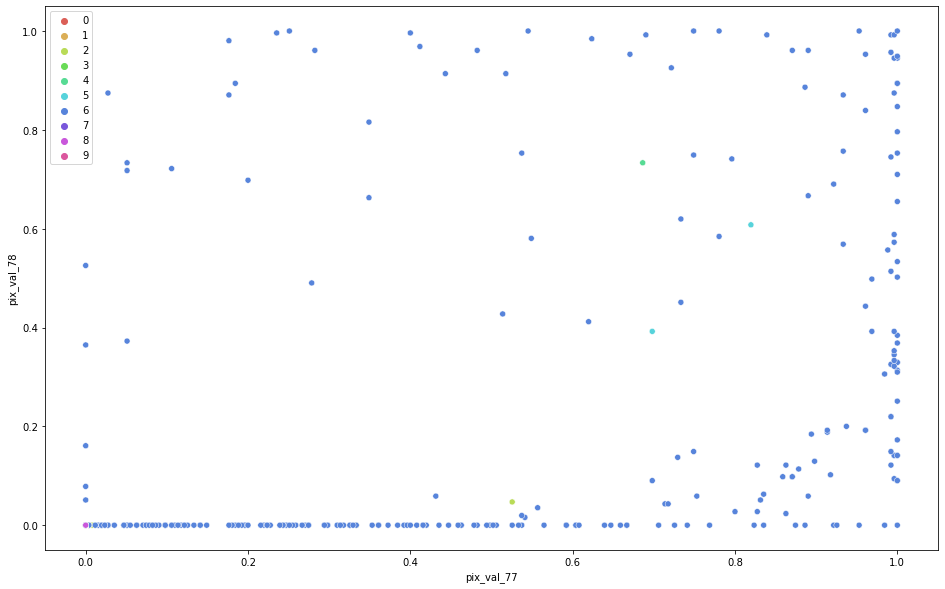

In [55]:
plt.figure(figsize=(16, 10))
color = sns.color_palette("hls", 10)
sns.scatterplot(x="pix_val_77", y="pix_val_78", hue="actual_class",  palette=color, data = pixel_df, legend="full")
plt.legend(loc='upper left');

Let's find the pattern to which the hidden node maximally responds.

In [56]:
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [57]:
def generate_pattern(layer_name, size=28):
    # Build a loss function that maximizes the activation
    # of the nth filter of the layer considered.
    K = tf.keras.backend
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output)

    # Compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, model.input)[0]

    # Normalization trick: we normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    # This function returns the loss and grads given the input picture
    iterate = K.function([model.input], [loss, grads])
    
    # We start from a gray image with some noise
    input_img_data = np.random.random((1, size*size)) * 20 + 128.

    # Run gradient ascent for 1000 steps
    step = 1.
    for i in range(1000):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step

        
    img = input_img_data[0]
    return deprocess_image(img)

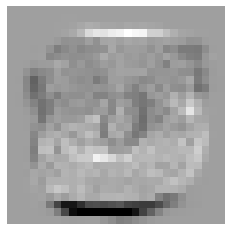

In [58]:
# Find and display the pattern that maximizes the activation value
max_img = generate_pattern('dense')
plt.imshow(max_img.reshape(28,28), cmap="binary")
plt.axis('off')
plt.show()

In [59]:
 # print activation value for max_img
max_img_act_value = activation_model.predict(max_img.reshape(-1,784))[0].item(0)
max_img_class = activation_model.predict(max_img.reshape(-1,784))[1].argmax()
print(f"The activation value for max_img is {max_img_act_value}.")
print(f"The model thinks this is an image of a {max_img_class}.")   # check this!

The activation value for max_img is 3831.807861328125.
The model thinks this is an image of a 7.


## 4) Experiment 2 - ANN with 1 Hidden Layer with 2 Nodes

### 4.1) Construct Model

Let's construct our an artificial neural network to classify images as integers.

In [ ]:
k.clear_session()

model = Sequential([
    Dense(input_shape=[784], units=1, activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(name = "output_layer", units = 10, activation = tf.nn.softmax)
])

In [ ]:
model.summary()

In [ ]:
model.compile(optimizer='rmsprop',
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

In [ ]:
#tf.keras.model.fit
#https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit

#tf.keras.callbacks.EarlyStopping
#https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping


history = model.fit(
    x_train_norm
    ,y_train_encoded
    ,epochs = 200
    ,validation_split=(5000/60000)
    ,callbacks=[tf.keras.callbacks.ModelCheckpoint("DNN_model.h5",save_best_only=True,save_weights_only=False)
                ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
    )

### 4.2) Evaluate Model Performance on Testing Dataset

Let's apply the model to the testing dataset and evaluate its performance.

In [ ]:
model = tf.keras.models.load_model("DNN_model.h5")
print(f"Test acc: {model.evaluate(x_test_norm, y_test_encoded)[1]:.3f}")

In [ ]:
# loss, accuracy = model.evaluate(x_test_norm, y_test_encoded)
# print('test set accuracy: ', accuracy * 100)

In [ ]:
preds = model.predict(x_test_norm)
print('shape of preds: ', preds.shape)

As part of our model evaluation, let's look at the first 25 images by plotting the test set images along with their predicted and actual labels to understand how the trained model actually performed on specific example images.

In [ ]:
plt.figure(figsize = (12, 8))

start_index = 0

for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    pred = np.argmax(preds[start_index + i])
    actual = np.argmax(y_test_encoded[start_index + i])
    col = 'g'
    if pred != actual:
        col = 'r'
    plt.xlabel('i={} | pred={} | true={}'.format(start_index + i, pred, actual), color = col)
    plt.imshow(x_test[start_index + i], cmap='binary')
plt.show()

Let's use `Matplotlib` to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

In [ ]:
history_dict = history.history
history_dict.keys()

In [ ]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

In [ ]:
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

Let's examine precision and recall performance metrics for each of the prediction classes.

In [ ]:
pred1= model.predict(x_test_norm)
pred1=np.argmax(pred1, axis=1)

print_validation_report(y_test, pred1)

Let's create a table that visualizes the model output for each of the first 20 images. These outputs can be thought of as the model's expression of the probability that each image corresponds to each digit class.

<div class="alert alert-block alert-info">
    <b>Correlation matrix that measures the linear relationships</b><br>
    https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html
    </div>

In [ ]:
# Get the predicted classes:
# pred_classes = model.predict_classes(x_train_norm)# give deprecation warning
pred_classes = np.argmax(model.predict(x_test_norm), axis=-1)
pred_classes;

In [ ]:
conf_mx = tf.math.confusion_matrix(y_test, pred_classes)
conf_mx;

cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)
df = pd.DataFrame(preds[0:20], columns = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
df.style.format("{:.2%}").background_gradient(cmap=cm)

Let's create a confusion matrix that visualizes the model performance on testing data.

In [ ]:
plot_confusion_matrix(y_test,pred_classes)

In [ ]:
############################## INSERT COMMENTARY ABOUT MISCLASSIFIED DIGITS ##########################################

In [ ]:
cl_a, cl_b = 3, 6
X_aa = x_test_norm[(y_test == cl_a) & (pred_classes == cl_a)]
X_ab = x_test_norm[(y_test == cl_a) & (pred_classes == cl_b)]
X_ba = x_test_norm[(y_test == cl_b) & (pred_classes == cl_a)]
X_bb = x_test_norm[(y_test == cl_b) & (pred_classes == cl_b)]

plt.figure(figsize=(16,8))

p1 = plt.subplot(221)
p2 = plt.subplot(222)
p3 = plt.subplot(223)
p4 = plt.subplot(224)

plot_digits(X_aa[:25], p1, images_per_row=5);
plot_digits(X_ab[:25], p2, images_per_row=5);
plot_digits(X_ba[:25], p3, images_per_row=5);
plot_digits(X_bb[:25], p4, images_per_row=5);


p1.set_title(f"{cl_a}'s classified as {cl_a}'s")
p2.set_title(f"{cl_a}'s classified as {cl_b}'s")
p3.set_title(f"{cl_b}'s classified as {cl_a}'s")
p4.set_title(f"{cl_b}'s classified as {cl_b}'s")

# plt.savefig("error_analysis_digits_plot_EXP1_valid")

plt.show()

### 4.3) Examine Model Activation Values

To get the activation values of the hidden nodes, we need to create a new model, `activation_model`, that takes the same input as our current model but outputs the activation value of the hidden layer, i.e. of the hidden node. Then use the `predict` function to get the activation values.

In [ ]:
# Extracts the outputs of the 2 layers:
layer_outputs = [layer.output for layer in model.layers]

# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

print(f"There are {len(layer_outputs)} layers")
layer_outputs; # description of the layers



# Get the outputs of all the hidden nodes for each of the 60000 training images
activations = activation_model.predict(x_train_norm)
hidden_layer_activation = activations[0]
output_layer_activations = activations[1]
hidden_layer_activation.shape   #  each of the 128 hidden nodes has one activation value per training image



output_layer_activations.shape



print(f"The maximum activation value of the hidden nodes in the hidden layer is \
{hidden_layer_activation.max()}")



# Some stats about the output layer as an aside...
np.set_printoptions(suppress = True)  # display probabilities as decimals and NOT in scientific notation
ouput_layer_activation = activations[1]
print(f"The output node has shape {ouput_layer_activation.shape}")
print(f"The output for the first image are {ouput_layer_activation[0].round(4)}")
print(f"The sum of the probabilities is (approximately) {ouput_layer_activation[0].sum()}")



#Get the dataframe of all the node values
activation_data = {'actual_class':y_train}
for k in range(0,1):
    activation_data[f"act_val_{k}"] = hidden_layer_activation[:,k]

activation_df = pd.DataFrame(activation_data)
activation_df.head(15).round(3).T

Let's visualize these activation values via boxplots.

In [ ]:
# To see how closely the hidden node activation values correlate with the class labels
# Let us use seaborn for the boxplots this time.
plt.figure(figsize=(16,10))
bplot = sns.boxplot(y='act_val_0', x='actual_class',
                 data=activation_df[['act_val_0','actual_class']],
                 width=0.5,
                 palette="colorblind")

In [ ]:
activation_df.groupby("actual_class")["act_val_0"].apply(lambda x: [round(min(x.tolist()),2),
 round(max(x.tolist()),2)]).reset_index().rename(columns={"act_val_0": "range_of_act_values"})

Let's get activation values of the pixel values.

We can create a dataframe with pixel values and class labels.

In [ ]:
#Get the dataframe of all the pixel values
pixel_data = {'actual_class':y_train}
for k in range(0,784):
    pixel_data[f"pix_val_{k}"] = x_train_norm[:,k]
pixel_df = pd.DataFrame(pixel_data)
pixel_df.head(15).round(3).T

In [ ]:
pixel_df.pix_val_77.value_counts()

In [ ]:
pixel_df.pix_val_78.value_counts()

Use a scatter plot to visualize the predicive power of the pixel values at two fixed locations in the image, i.e. how well the pixel values at two fixed locations in the image "predict" the class labels.

We use a scatter plot to determine the correlation between the `pix_val_77` and `pix_val_78` values and the `actual_class` values.

In [ ]:
plt.figure(figsize=(16, 10))
color = sns.color_palette("hls", 10)
sns.scatterplot(x="pix_val_77", y="pix_val_78", hue="actual_class",  palette=color, data = pixel_df, legend="full")
plt.legend(loc='upper left');

## 5)  Experiment 3 - ANN with 1 Hidden Layer with ______________________ Nodes

### 5.1) Construct Model

Let's construct our an artificial neural network to classify images as integers.

In [ ]:
k.clear_session()

model = Sequential([
    Dense(input_shape=[784], units=1, activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(name = "output_layer", units = 10, activation = tf.nn.softmax)
])

In [ ]:
model.summary()

In [ ]:
model.compile(optimizer='rmsprop',
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

In [ ]:
#tf.keras.model.fit
#https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit

#tf.keras.callbacks.EarlyStopping
#https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping


history = model.fit(
    x_train_norm
    ,y_train_encoded
    ,epochs = 200
    ,validation_split=(5000/60000)
    ,callbacks=[tf.keras.callbacks.ModelCheckpoint("DNN_model.h5",save_best_only=True,save_weights_only=False)
                ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
    )

### 5.2) Evaluate Model Performance on Testing Dataset

Let's apply the model to the testing dataset and evaluate its performance.

In [ ]:
model = tf.keras.models.load_model("DNN_model.h5")
print(f"Test acc: {model.evaluate(x_test_norm, y_test_encoded)[1]:.3f}")

In [ ]:
# loss, accuracy = model.evaluate(x_test_norm, y_test_encoded)
# print('test set accuracy: ', accuracy * 100)

In [ ]:
preds = model.predict(x_test_norm)
print('shape of preds: ', preds.shape)

As part of our model evaluation, let's look at the first 25 images by plotting the test set images along with their predicted and actual labels to understand how the trained model actually performed on specific example images.

In [ ]:
plt.figure(figsize = (12, 8))

start_index = 0

for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    pred = np.argmax(preds[start_index + i])
    actual = np.argmax(y_test_encoded[start_index + i])
    col = 'g'
    if pred != actual:
        col = 'r'
    plt.xlabel('i={} | pred={} | true={}'.format(start_index + i, pred, actual), color = col)
    plt.imshow(x_test[start_index + i], cmap='binary')
plt.show()

Let's use `Matplotlib` to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

In [ ]:
history_dict = history.history
history_dict.keys()

In [ ]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

In [ ]:
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

Let's examine precision and recall performance metrics for each of the prediction classes.

In [ ]:
pred1= model.predict(x_test_norm)
pred1=np.argmax(pred1, axis=1)

print_validation_report(y_test, pred1)

Let's create a table that visualizes the model output for each of the first 20 images. These outputs can be thought of as the model's expression of the probability that each image corresponds to each digit class.

<div class="alert alert-block alert-info">
    <b>Correlation matrix that measures the linear relationships</b><br>
    https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html
    </div>

In [ ]:
# Get the predicted classes:
# pred_classes = model.predict_classes(x_train_norm)# give deprecation warning
pred_classes = np.argmax(model.predict(x_test_norm), axis=-1)
pred_classes;

In [ ]:
conf_mx = tf.math.confusion_matrix(y_test, pred_classes)
conf_mx;

cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)
df = pd.DataFrame(preds[0:20], columns = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
df.style.format("{:.2%}").background_gradient(cmap=cm)

Let's create a confusion matrix that visualizes model performance on testing data.

In [ ]:
plot_confusion_matrix(y_test,pred_classes)

In [ ]:
############################### INSERT COMMENTARY ABOUT MISCLASSIFIED DIGITS #########################################

In [ ]:
cl_a, cl_b = 3, 6
X_aa = x_test_norm[(y_test == cl_a) & (pred_classes == cl_a)]
X_ab = x_test_norm[(y_test == cl_a) & (pred_classes == cl_b)]
X_ba = x_test_norm[(y_test == cl_b) & (pred_classes == cl_a)]
X_bb = x_test_norm[(y_test == cl_b) & (pred_classes == cl_b)]

plt.figure(figsize=(16,8))

p1 = plt.subplot(221)
p2 = plt.subplot(222)
p3 = plt.subplot(223)
p4 = plt.subplot(224)

plot_digits(X_aa[:25], p1, images_per_row=5);
plot_digits(X_ab[:25], p2, images_per_row=5);
plot_digits(X_ba[:25], p3, images_per_row=5);
plot_digits(X_bb[:25], p4, images_per_row=5);


p1.set_title(f"{cl_a}'s classified as {cl_a}'s")
p2.set_title(f"{cl_a}'s classified as {cl_b}'s")
p3.set_title(f"{cl_b}'s classified as {cl_a}'s")
p4.set_title(f"{cl_b}'s classified as {cl_b}'s")

# plt.savefig("error_analysis_digits_plot_EXP1_valid")

plt.show()

### 5.3) Examine Model Activation Values

To get the activation values of the hidden nodes, we need to create a new model, `activation_model`, that takes the same input as our current model but outputs the activation value of the hidden layer, i.e. of the hidden node. Then use the `predict` function to get the activation values.

In [ ]:
# Extracts the outputs of the 2 layers:
layer_outputs = [layer.output for layer in model.layers]

# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

print(f"There are {len(layer_outputs)} layers")
layer_outputs; # description of the layers



# Get the outputs of all the hidden nodes for each of the 60000 training images
activations = activation_model.predict(x_train_norm)
hidden_layer_activation = activations[0]
output_layer_activations = activations[1]
hidden_layer_activation.shape   #  each of the 128 hidden nodes has one activation value per training image



output_layer_activations.shape



print(f"The maximum activation value of the hidden nodes in the hidden layer is \
{hidden_layer_activation.max()}")



# Some stats about the output layer as an aside...
np.set_printoptions(suppress = True)  # display probabilities as decimals and NOT in scientific notation
ouput_layer_activation = activations[1]
print(f"The output node has shape {ouput_layer_activation.shape}")
print(f"The output for the first image are {ouput_layer_activation[0].round(4)}")
print(f"The sum of the probabilities is (approximately) {ouput_layer_activation[0].sum()}")



#Get the dataframe of all the node values
activation_data = {'actual_class':y_train}
for k in range(0,1):
    activation_data[f"act_val_{k}"] = hidden_layer_activation[:,k]

activation_df = pd.DataFrame(activation_data)
activation_df.head(15).round(3).T

Let's visualize these activation values via boxplots.

In [ ]:
# To see how closely the hidden node activation values correlate with the class labels
# Let us use seaborn for the boxplots this time.
plt.figure(figsize=(16,10))
bplot = sns.boxplot(y='act_val_0', x='actual_class',
                 data=activation_df[['act_val_0','actual_class']],
                 width=0.5,
                 palette="colorblind")

In [ ]:
activation_df.groupby("actual_class")["act_val_0"].apply(lambda x: [round(min(x.tolist()),2),
 round(max(x.tolist()),2)]).reset_index().rename(columns={"act_val_0": "range_of_act_values"})

Let's visualize activation values of the pixel values.

We can create a dataframe with pixel values and class labels.

In [ ]:
#Get the dataframe of all the pixel values
pixel_data = {'actual_class':y_train}
for k in range(0,784):
    pixel_data[f"pix_val_{k}"] = x_train_norm[:,k]
pixel_df = pd.DataFrame(pixel_data)
pixel_df.head(15).round(3).T

In [ ]:
pixel_df.pix_val_77.value_counts()

In [ ]:
pixel_df.pix_val_78.value_counts()

Use a scatter plot to visualize the predicive power of the pixel values at two fixed locations in the image, i.e. how well the pixel values at two fixed locations in the image "predict" the class labels.

We use a scatter plot to determine the correlation between the `pix_val_77` and `pix_val_78` values and the `actual_class` values.

In [ ]:
plt.figure(figsize=(16, 10))
color = sns.color_palette("hls", 10)
sns.scatterplot(x="pix_val_77", y="pix_val_78", hue="actual_class",  palette=color, data = pixel_df, legend="full")
plt.legend(loc='upper left');

## 6) Experiment 4 - ANN with 1 Hidden Layer with ___________________ Nodes

### 6.1) Construct Model

Let's construct our an artificial neural network to classify images as integers.

In [ ]:
k.clear_session()

model = Sequential([
    Dense(input_shape=[784], units=1, activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(name = "output_layer", units = 10, activation = tf.nn.softmax)
])

In [ ]:
model.summary()

In [ ]:
model.compile(optimizer='rmsprop',
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

In [ ]:
#tf.keras.model.fit
#https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit

#tf.keras.callbacks.EarlyStopping
#https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping


history = model.fit(
    x_train_norm
    ,y_train_encoded
    ,epochs = 200
    ,validation_split=(5000/60000)
    ,callbacks=[tf.keras.callbacks.ModelCheckpoint("DNN_model.h5",save_best_only=True,save_weights_only=False)
                ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
    )

### 6.2) Evaluate Model Performance on Testing Dataset

Let's apply the model to the testing dataset and evaluate its performance.

In [ ]:
model = tf.keras.models.load_model("DNN_model.h5")
print(f"Test acc: {model.evaluate(x_test_norm, y_test_encoded)[1]:.3f}")

In [ ]:
# loss, accuracy = model.evaluate(x_test_norm, y_test_encoded)
# print('test set accuracy: ', accuracy * 100)

In [ ]:
preds = model.predict(x_test_norm)
print('shape of preds: ', preds.shape)

As part of our model evaluation, let's look at the first 25 images by plotting the test set images along with their predicted and actual labels to understand how the trained model actually performed on specific example images.

In [ ]:
plt.figure(figsize = (12, 8))

start_index = 0

for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    pred = np.argmax(preds[start_index + i])
    actual = np.argmax(y_test_encoded[start_index + i])
    col = 'g'
    if pred != actual:
        col = 'r'
    plt.xlabel('i={} | pred={} | true={}'.format(start_index + i, pred, actual), color = col)
    plt.imshow(x_test[start_index + i], cmap='binary')
plt.show()

Let's use `Matplotlib` to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

In [ ]:
history_dict = history.history
history_dict.keys()

In [ ]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

In [ ]:
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

Let's examine precision and recall performance metrics for each of the prediction classes.

In [ ]:
pred1= model.predict(x_test_norm)
pred1=np.argmax(pred1, axis=1)

print_validation_report(y_test, pred1)

Let's create a table that visualizes the model output for each of the first 20 images. These outputs can be thought of as the model's expression of the probability that each image corresponds to each digit class.

<div class="alert alert-block alert-info">
    <b>Correlation matrix that measures the linear relationships</b><br>
    https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html
    </div>

In [ ]:
# Get the predicted classes:
# pred_classes = model.predict_classes(x_train_norm)# give deprecation warning
pred_classes = np.argmax(model.predict(x_test_norm), axis=-1)
pred_classes;

In [ ]:
conf_mx = tf.math.confusion_matrix(y_test, pred_classes)
conf_mx;

cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)
df = pd.DataFrame(preds[0:20], columns = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
df.style.format("{:.2%}").background_gradient(cmap=cm)

Let's create a confusion matrix that visualizes model performance on testing data.

In [ ]:
plot_confusion_matrix(y_test,pred_classes)

In [ ]:
############################# INSERT COMMENTARY ABOUT MISCLASSIFIED DIGITS ###########################################

In [ ]:
cl_a, cl_b = 3, 6
X_aa = x_test_norm[(y_test == cl_a) & (pred_classes == cl_a)]
X_ab = x_test_norm[(y_test == cl_a) & (pred_classes == cl_b)]
X_ba = x_test_norm[(y_test == cl_b) & (pred_classes == cl_a)]
X_bb = x_test_norm[(y_test == cl_b) & (pred_classes == cl_b)]

plt.figure(figsize=(16,8))

p1 = plt.subplot(221)
p2 = plt.subplot(222)
p3 = plt.subplot(223)
p4 = plt.subplot(224)

plot_digits(X_aa[:25], p1, images_per_row=5);
plot_digits(X_ab[:25], p2, images_per_row=5);
plot_digits(X_ba[:25], p3, images_per_row=5);
plot_digits(X_bb[:25], p4, images_per_row=5);


p1.set_title(f"{cl_a}'s classified as {cl_a}'s")
p2.set_title(f"{cl_a}'s classified as {cl_b}'s")
p3.set_title(f"{cl_b}'s classified as {cl_a}'s")
p4.set_title(f"{cl_b}'s classified as {cl_b}'s")

# plt.savefig("error_analysis_digits_plot_EXP1_valid")

plt.show()

### 6.3) Examine Model Activation Values

To get the activation values of the hidden nodes, we need to create a new model, `activation_model`, that takes the same input as our current model but outputs the activation value of the hidden layer, i.e. of the hidden node. Then use the `predict` function to get the activation values.

In [ ]:
# Extracts the outputs of the 2 layers:
layer_outputs = [layer.output for layer in model.layers]

# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

print(f"There are {len(layer_outputs)} layers")
layer_outputs; # description of the layers



# Get the outputs of all the hidden nodes for each of the 60000 training images
activations = activation_model.predict(x_train_norm)
hidden_layer_activation = activations[0]
output_layer_activations = activations[1]
hidden_layer_activation.shape   #  each of the 128 hidden nodes has one activation value per training image



output_layer_activations.shape



print(f"The maximum activation value of the hidden nodes in the hidden layer is \
{hidden_layer_activation.max()}")



# Some stats about the output layer as an aside...
np.set_printoptions(suppress = True)  # display probabilities as decimals and NOT in scientific notation
ouput_layer_activation = activations[1]
print(f"The output node has shape {ouput_layer_activation.shape}")
print(f"The output for the first image are {ouput_layer_activation[0].round(4)}")
print(f"The sum of the probabilities is (approximately) {ouput_layer_activation[0].sum()}")



#Get the dataframe of all the node values
activation_data = {'actual_class':y_train}
for k in range(0,1):
    activation_data[f"act_val_{k}"] = hidden_layer_activation[:,k]

activation_df = pd.DataFrame(activation_data)
activation_df.head(15).round(3).T

Let's visualize these activation values via boxplots.

In [ ]:
# To see how closely the hidden node activation values correlate with the class labels
# Let us use seaborn for the boxplots this time.
plt.figure(figsize=(16,10))
bplot = sns.boxplot(y='act_val_0', x='actual_class',
                 data=activation_df[['act_val_0','actual_class']],
                 width=0.5,
                 palette="colorblind")

In [ ]:
activation_df.groupby("actual_class")["act_val_0"].apply(lambda x: [round(min(x.tolist()),2),
 round(max(x.tolist()),2)]).reset_index().rename(columns={"act_val_0": "range_of_act_values"})

Let's visualize the activation values of the pixel values.

We can create a dataframe with pixel values and class labels.

In [ ]:
#Get the dataframe of all the pixel values
pixel_data = {'actual_class':y_train}
for k in range(0,784):
    pixel_data[f"pix_val_{k}"] = x_train_norm[:,k]
pixel_df = pd.DataFrame(pixel_data)
pixel_df.head(15).round(3).T

In [ ]:
pixel_df.pix_val_77.value_counts()

In [ ]:
pixel_df.pix_val_78.value_counts()

Use a scatter plot to visualize the predicive power of the pixel values at two fixed locations in the image, i.e. how well the pixel values at two fixed locations in the image "predict" the class labels.

We use a scatter plot to determine the correlation between the `pix_val_77` and `pix_val_78` values and the `actual_class` values.

In [ ]:
plt.figure(figsize=(16, 10))
color = sns.color_palette("hls", 10)
sns.scatterplot(x="pix_val_77", y="pix_val_78", hue="actual_class",  palette=color, data = pixel_df, legend="full")
plt.legend(loc='upper left');

## 7) Experiment 5 - ANN with 1 Hidden Layer with _________________________________ Nodes

### 7.1) Construct Model

Let's construct our an artificial neural network to classify images as integers.

In [ ]:
k.clear_session()

model = Sequential([
    Dense(input_shape=[784], units=1, activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(name = "output_layer", units = 10, activation = tf.nn.softmax)
])

In [ ]:
model.summary()

In [ ]:
model.compile(optimizer='rmsprop',
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

In [ ]:
#tf.keras.model.fit
#https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit

#tf.keras.callbacks.EarlyStopping
#https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping


history = model.fit(
    x_train_norm
    ,y_train_encoded
    ,epochs = 200
    ,validation_split=(5000/60000)
    ,callbacks=[tf.keras.callbacks.ModelCheckpoint("DNN_model.h5",save_best_only=True,save_weights_only=False)
                ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
    )

### 7.2) Evaluate Model Performance on Testing Dataset

Let's apply the model to the testing dataset and evaluate its performance.

In [ ]:
model = tf.keras.models.load_model("DNN_model.h5")
print(f"Test acc: {model.evaluate(x_test_norm, y_test_encoded)[1]:.3f}")

In [ ]:
# loss, accuracy = model.evaluate(x_test_norm, y_test_encoded)
# print('test set accuracy: ', accuracy * 100)

In [ ]:
preds = model.predict(x_test_norm)
print('shape of preds: ', preds.shape)

As part of our model evaluation, let's look at the first 25 images by plotting the test set images along with their predicted and actual labels to understand how the trained model actually performed on specific example images.

In [ ]:
plt.figure(figsize = (12, 8))

start_index = 0

for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    pred = np.argmax(preds[start_index + i])
    actual = np.argmax(y_test_encoded[start_index + i])
    col = 'g'
    if pred != actual:
        col = 'r'
    plt.xlabel('i={} | pred={} | true={}'.format(start_index + i, pred, actual), color = col)
    plt.imshow(x_test[start_index + i], cmap='binary')
plt.show()

Let's use `Matplotlib` to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

In [ ]:
history_dict = history.history
history_dict.keys()

In [ ]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

In [ ]:
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

Let's examine precision and recall performance metrics for each of the prediction classes.

In [ ]:
pred1= model.predict(x_test_norm)
pred1=np.argmax(pred1, axis=1)

print_validation_report(y_test, pred1)

Let's create a table that visualizes the model output for each of the first 20 images. These outputs can be thought of as the model's expression of the probability that each image corresponds to each digit class.

<div class="alert alert-block alert-info">
    <b>Correlation matrix that measures the linear relationships</b><br>
    https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html
    </div>

In [ ]:
# Get the predicted classes:
# pred_classes = model.predict_classes(x_train_norm)# give deprecation warning
pred_classes = np.argmax(model.predict(x_test_norm), axis=-1)
pred_classes;

In [ ]:
conf_mx = tf.math.confusion_matrix(y_test, pred_classes)
conf_mx;

cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)
df = pd.DataFrame(preds[0:20], columns = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
df.style.format("{:.2%}").background_gradient(cmap=cm)

Let's create a confusion matrix that visualizes model performance on testing data.

In [ ]:
plot_confusion_matrix(y_test,pred_classes)

In [ ]:
############################ INSERT COMMENTARY ABOUT MISCLASSIFIED DIGITS ###########################################

In [ ]:
cl_a, cl_b = 3, 6
X_aa = x_test_norm[(y_test == cl_a) & (pred_classes == cl_a)]
X_ab = x_test_norm[(y_test == cl_a) & (pred_classes == cl_b)]
X_ba = x_test_norm[(y_test == cl_b) & (pred_classes == cl_a)]
X_bb = x_test_norm[(y_test == cl_b) & (pred_classes == cl_b)]

plt.figure(figsize=(16,8))

p1 = plt.subplot(221)
p2 = plt.subplot(222)
p3 = plt.subplot(223)
p4 = plt.subplot(224)

plot_digits(X_aa[:25], p1, images_per_row=5);
plot_digits(X_ab[:25], p2, images_per_row=5);
plot_digits(X_ba[:25], p3, images_per_row=5);
plot_digits(X_bb[:25], p4, images_per_row=5);


p1.set_title(f"{cl_a}'s classified as {cl_a}'s")
p2.set_title(f"{cl_a}'s classified as {cl_b}'s")
p3.set_title(f"{cl_b}'s classified as {cl_a}'s")
p4.set_title(f"{cl_b}'s classified as {cl_b}'s")

# plt.savefig("error_analysis_digits_plot_EXP1_valid")

plt.show()

### 7.3) Examine Model Activation Values

To get the activation values of the hidden nodes, we need to create a new model, `activation_model`, that takes the same input as our current model but outputs the activation value of the hidden layer, i.e. of the hidden node. Then use the `predict` function to get the activation values.

In [ ]:
# Extracts the outputs of the 2 layers:
layer_outputs = [layer.output for layer in model.layers]

# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

print(f"There are {len(layer_outputs)} layers")
layer_outputs; # description of the layers



# Get the outputs of all the hidden nodes for each of the 60000 training images
activations = activation_model.predict(x_train_norm)
hidden_layer_activation = activations[0]
output_layer_activations = activations[1]
hidden_layer_activation.shape   #  each of the 128 hidden nodes has one activation value per training image



output_layer_activations.shape



print(f"The maximum activation value of the hidden nodes in the hidden layer is \
{hidden_layer_activation.max()}")



# Some stats about the output layer as an aside...
np.set_printoptions(suppress = True)  # display probabilities as decimals and NOT in scientific notation
ouput_layer_activation = activations[1]
print(f"The output node has shape {ouput_layer_activation.shape}")
print(f"The output for the first image are {ouput_layer_activation[0].round(4)}")
print(f"The sum of the probabilities is (approximately) {ouput_layer_activation[0].sum()}")



#Get the dataframe of all the node values
activation_data = {'actual_class':y_train}
for k in range(0,1):
    activation_data[f"act_val_{k}"] = hidden_layer_activation[:,k]

activation_df = pd.DataFrame(activation_data)
activation_df.head(15).round(3).T

Let's visualize these activation values via boxplots.

In [ ]:
# To see how closely the hidden node activation values correlate with the class labels
# Let us use seaborn for the boxplots this time.
plt.figure(figsize=(16,10))
bplot = sns.boxplot(y='act_val_0', x='actual_class',
                 data=activation_df[['act_val_0','actual_class']],
                 width=0.5,
                 palette="colorblind")

In [ ]:
activation_df.groupby("actual_class")["act_val_0"].apply(lambda x: [round(min(x.tolist()),2),
 round(max(x.tolist()),2)]).reset_index().rename(columns={"act_val_0": "range_of_act_values"})

Let's visualize the activation values of the pixel values.

We can create a dataframe with pixel values and class labels.

In [ ]:
#Get the dataframe of all the pixel values
pixel_data = {'actual_class':y_train}
for k in range(0,784):
    pixel_data[f"pix_val_{k}"] = x_train_norm[:,k]
pixel_df = pd.DataFrame(pixel_data)
pixel_df.head(15).round(3).T

In [ ]:
pixel_df.pix_val_77.value_counts()

In [ ]:
pixel_df.pix_val_78.value_counts()

Use a scatter plot to visualize the predicive power of the pixel values at two fixed locations in the image, i.e. how well the pixel values at two fixed locations in the image "predict" the class labels.

We use a scatter plot to determine the correlation between the `pix_val_77` and `pix_val_78` values and the `actual_class` values.

In [ ]:
plt.figure(figsize=(16, 10))
color = sns.color_palette("hls", 10)
sns.scatterplot(x="pix_val_77", y="pix_val_78", hue="actual_class",  palette=color, data = pixel_df, legend="full")
plt.legend(loc='upper left');

## 8) Experiment 6 - ANN with 1 Hidden Layer with _______________________________ Nodes

### 8.1) Construct Model

Let's construct our an artificial neural network to classify images as integers.

In [ ]:
k.clear_session()

model = Sequential([
    Dense(input_shape=[784], units=1, activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(name = "output_layer", units = 10, activation = tf.nn.softmax)
])

In [ ]:
model.summary()

In [ ]:
model.compile(optimizer='rmsprop',
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

In [ ]:
#tf.keras.model.fit
#https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit

#tf.keras.callbacks.EarlyStopping
#https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping


history = model.fit(
    x_train_norm
    ,y_train_encoded
    ,epochs = 200
    ,validation_split=(5000/60000)
    ,callbacks=[tf.keras.callbacks.ModelCheckpoint("DNN_model.h5",save_best_only=True,save_weights_only=False)
                ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
    )

### 8.2) Evaluate Model Performance on Testing Dataset

Let's apply the model to the testing dataset and evaluate its performance.

In [ ]:
model = tf.keras.models.load_model("DNN_model.h5")
print(f"Test acc: {model.evaluate(x_test_norm, y_test_encoded)[1]:.3f}")

In [ ]:
# loss, accuracy = model.evaluate(x_test_norm, y_test_encoded)
# print('test set accuracy: ', accuracy * 100)

In [ ]:
preds = model.predict(x_test_norm)
print('shape of preds: ', preds.shape)

As part of our model evaluation, let's look at the first 25 images by plotting the test set images along with their predicted and actual labels to understand how the trained model actually performed on specific example images.

In [ ]:
plt.figure(figsize = (12, 8))

start_index = 0

for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    pred = np.argmax(preds[start_index + i])
    actual = np.argmax(y_test_encoded[start_index + i])
    col = 'g'
    if pred != actual:
        col = 'r'
    plt.xlabel('i={} | pred={} | true={}'.format(start_index + i, pred, actual), color = col)
    plt.imshow(x_test[start_index + i], cmap='binary')
plt.show()

Let's use `Matplotlib` to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

In [ ]:
history_dict = history.history
history_dict.keys()

In [ ]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

In [ ]:
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

Let's examine precision and recall performance metrics for each of the prediction classes.

In [ ]:
pred1= model.predict(x_test_norm)
pred1=np.argmax(pred1, axis=1)

print_validation_report(y_test, pred1)

Let's create a table that visualizes the model output for each of the first 20 images. These outputs can be thought of as the model's expression of the probability that each image corresponds to each digit class.

<div class="alert alert-block alert-info">
    <b>Correlation matrix that measures the linear relationships</b><br>
    https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html
    </div>

In [ ]:
# Get the predicted classes:
# pred_classes = model.predict_classes(x_train_norm)# give deprecation warning
pred_classes = np.argmax(model.predict(x_test_norm), axis=-1)
pred_classes;

In [ ]:
conf_mx = tf.math.confusion_matrix(y_test, pred_classes)
conf_mx;

cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)
df = pd.DataFrame(preds[0:20], columns = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
df.style.format("{:.2%}").background_gradient(cmap=cm)

Let's create a confusion matrix that visualizes model performance on testing data.

In [ ]:
plot_confusion_matrix(y_test,pred_classes)

In [ ]:
####################### INSERT COMMENTARY ABOUT MISCLASSIFIED DIGITS ##############################################

In [ ]:
cl_a, cl_b = 3, 6
X_aa = x_test_norm[(y_test == cl_a) & (pred_classes == cl_a)]
X_ab = x_test_norm[(y_test == cl_a) & (pred_classes == cl_b)]
X_ba = x_test_norm[(y_test == cl_b) & (pred_classes == cl_a)]
X_bb = x_test_norm[(y_test == cl_b) & (pred_classes == cl_b)]

plt.figure(figsize=(16,8))

p1 = plt.subplot(221)
p2 = plt.subplot(222)
p3 = plt.subplot(223)
p4 = plt.subplot(224)

plot_digits(X_aa[:25], p1, images_per_row=5);
plot_digits(X_ab[:25], p2, images_per_row=5);
plot_digits(X_ba[:25], p3, images_per_row=5);
plot_digits(X_bb[:25], p4, images_per_row=5);


p1.set_title(f"{cl_a}'s classified as {cl_a}'s")
p2.set_title(f"{cl_a}'s classified as {cl_b}'s")
p3.set_title(f"{cl_b}'s classified as {cl_a}'s")
p4.set_title(f"{cl_b}'s classified as {cl_b}'s")

# plt.savefig("error_analysis_digits_plot_EXP1_valid")

plt.show()

### 8.3) Examine Model Activation Values

To get the activation values of the hidden nodes, we need to create a new model, `activation_model`, that takes the same input as our current model but outputs the activation value of the hidden layer, i.e. of the hidden node. Then use the `predict` function to get the activation values.

In [ ]:
# Extracts the outputs of the 2 layers:
layer_outputs = [layer.output for layer in model.layers]

# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

print(f"There are {len(layer_outputs)} layers")
layer_outputs; # description of the layers



# Get the outputs of all the hidden nodes for each of the 60000 training images
activations = activation_model.predict(x_train_norm)
hidden_layer_activation = activations[0]
output_layer_activations = activations[1]
hidden_layer_activation.shape   #  each of the 128 hidden nodes has one activation value per training image



output_layer_activations.shape



print(f"The maximum activation value of the hidden nodes in the hidden layer is \
{hidden_layer_activation.max()}")



# Some stats about the output layer as an aside...
np.set_printoptions(suppress = True)  # display probabilities as decimals and NOT in scientific notation
ouput_layer_activation = activations[1]
print(f"The output node has shape {ouput_layer_activation.shape}")
print(f"The output for the first image are {ouput_layer_activation[0].round(4)}")
print(f"The sum of the probabilities is (approximately) {ouput_layer_activation[0].sum()}")



#Get the dataframe of all the node values
activation_data = {'actual_class':y_train}
for k in range(0,1):
    activation_data[f"act_val_{k}"] = hidden_layer_activation[:,k]

activation_df = pd.DataFrame(activation_data)
activation_df.head(15).round(3).T

Let's visualize these activation values via boxplots.

In [ ]:
# To see how closely the hidden node activation values correlate with the class labels
# Let us use seaborn for the boxplots this time.
plt.figure(figsize=(16,10))
bplot = sns.boxplot(y='act_val_0', x='actual_class',
                 data=activation_df[['act_val_0','actual_class']],
                 width=0.5,
                 palette="colorblind")

In [ ]:
activation_df.groupby("actual_class")["act_val_0"].apply(lambda x: [round(min(x.tolist()),2),
 round(max(x.tolist()),2)]).reset_index().rename(columns={"act_val_0": "range_of_act_values"})

Let's visualize the activation values of the pixel values.

We can create a dataframe with pixel values and class labels.

In [ ]:
#Get the dataframe of all the pixel values
pixel_data = {'actual_class':y_train}
for k in range(0,784):
    pixel_data[f"pix_val_{k}"] = x_train_norm[:,k]
pixel_df = pd.DataFrame(pixel_data)
pixel_df.head(15).round(3).T

In [ ]:
pixel_df.pix_val_77.value_counts()

In [ ]:
pixel_df.pix_val_78.value_counts()

Use a scatter plot to visualize the predicive power of the pixel values at two fixed locations in the image, i.e. how well the pixel values at two fixed locations in the image "predict" the class labels.

We use a scatter plot to determine the correlation between the `pix_val_77` and `pix_val_78` values and the `actual_class` values.

In [ ]:
plt.figure(figsize=(16, 10))
color = sns.color_palette("hls", 10)
sns.scatterplot(x="pix_val_77", y="pix_val_78", hue="actual_class",  palette=color, data = pixel_df, legend="full")
plt.legend(loc='upper left');

## 9) Experiment 7 - ANN with 1 Hidden Layer with ____________________________ Nodes

### 9.1) Construct Model

Let's construct our an artificial neural network to classify images as integers.

In [ ]:
k.clear_session()

model = Sequential([
    Dense(input_shape=[784], units=1, activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(name = "output_layer", units = 10, activation = tf.nn.softmax)
])

In [ ]:
model.summary()

In [ ]:
model.compile(optimizer='rmsprop',
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

In [ ]:
#tf.keras.model.fit
#https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit

#tf.keras.callbacks.EarlyStopping
#https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping


history = model.fit(
    x_train_norm
    ,y_train_encoded
    ,epochs = 200
    ,validation_split=(5000/60000)
    ,callbacks=[tf.keras.callbacks.ModelCheckpoint("DNN_model.h5",save_best_only=True,save_weights_only=False)
                ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
    )

### 9.2) Evaluate Model Performance on Testing Dataset

Let's apply this model to the testing dataset and evaluate its performance.

In [ ]:
model = tf.keras.models.load_model("DNN_model.h5")
print(f"Test acc: {model.evaluate(x_test_norm, y_test_encoded)[1]:.3f}")

In [ ]:
# loss, accuracy = model.evaluate(x_test_norm, y_test_encoded)
# print('test set accuracy: ', accuracy * 100)

In [ ]:
preds = model.predict(x_test_norm)
print('shape of preds: ', preds.shape)

As part of our model evaluation, let's look at the first 25 images by plotting the test set images along with their predicted and actual labels to understand how the trained model actually performed on specific example images.

In [ ]:
plt.figure(figsize = (12, 8))

start_index = 0

for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    pred = np.argmax(preds[start_index + i])
    actual = np.argmax(y_test_encoded[start_index + i])
    col = 'g'
    if pred != actual:
        col = 'r'
    plt.xlabel('i={} | pred={} | true={}'.format(start_index + i, pred, actual), color = col)
    plt.imshow(x_test[start_index + i], cmap='binary')
plt.show()

Let's use `Matplotlib` to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

In [ ]:
history_dict = history.history
history_dict.keys()

In [ ]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

In [ ]:
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

Let's examine precision and recall performance metrics for each of the prediction classes.

In [ ]:
pred1= model.predict(x_test_norm)
pred1=np.argmax(pred1, axis=1)

print_validation_report(y_test, pred1)

Let's create a table that visualizes the model output for each of the first 20 images. These outputs can be thought of as the model's expression of the probability that each image corresponds to each digit class.

<div class="alert alert-block alert-info">
    <b>Correlation matrix that measures the linear relationships</b><br>
    https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html
    </div>

In [ ]:
# Get the predicted classes:
# pred_classes = model.predict_classes(x_train_norm)# give deprecation warning
pred_classes = np.argmax(model.predict(x_test_norm), axis=-1)
pred_classes;

In [ ]:
conf_mx = tf.math.confusion_matrix(y_test, pred_classes)
conf_mx;

cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)
df = pd.DataFrame(preds[0:20], columns = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
df.style.format("{:.2%}").background_gradient(cmap=cm)

Let's create a confusion matrix that visualizes model performance on testing data.

In [ ]:
plot_confusion_matrix(y_test,pred_classes)

In [ ]:
############################### INSERT COMMENTARY ABOUT MISCLASSIFIED DIGITS #######################################

In [ ]:
cl_a, cl_b = 3, 6
X_aa = x_test_norm[(y_test == cl_a) & (pred_classes == cl_a)]
X_ab = x_test_norm[(y_test == cl_a) & (pred_classes == cl_b)]
X_ba = x_test_norm[(y_test == cl_b) & (pred_classes == cl_a)]
X_bb = x_test_norm[(y_test == cl_b) & (pred_classes == cl_b)]

plt.figure(figsize=(16,8))

p1 = plt.subplot(221)
p2 = plt.subplot(222)
p3 = plt.subplot(223)
p4 = plt.subplot(224)

plot_digits(X_aa[:25], p1, images_per_row=5);
plot_digits(X_ab[:25], p2, images_per_row=5);
plot_digits(X_ba[:25], p3, images_per_row=5);
plot_digits(X_bb[:25], p4, images_per_row=5);


p1.set_title(f"{cl_a}'s classified as {cl_a}'s")
p2.set_title(f"{cl_a}'s classified as {cl_b}'s")
p3.set_title(f"{cl_b}'s classified as {cl_a}'s")
p4.set_title(f"{cl_b}'s classified as {cl_b}'s")

# plt.savefig("error_analysis_digits_plot_EXP1_valid")

plt.show()

### 9.3) Examine Model Activation Values

To get the activation values of the hidden nodes, we need to create a new model, `activation_model`, that takes the same input as our current model but outputs the activation value of the hidden layer, i.e. of the hidden node. Then use the `predict` function to get the activation values.

In [ ]:
# Extracts the outputs of the 2 layers:
layer_outputs = [layer.output for layer in model.layers]

# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

print(f"There are {len(layer_outputs)} layers")
layer_outputs; # description of the layers



# Get the outputs of all the hidden nodes for each of the 60000 training images
activations = activation_model.predict(x_train_norm)
hidden_layer_activation = activations[0]
output_layer_activations = activations[1]
hidden_layer_activation.shape   #  each of the 128 hidden nodes has one activation value per training image



output_layer_activations.shape



print(f"The maximum activation value of the hidden nodes in the hidden layer is \
{hidden_layer_activation.max()}")



# Some stats about the output layer as an aside...
np.set_printoptions(suppress = True)  # display probabilities as decimals and NOT in scientific notation
ouput_layer_activation = activations[1]
print(f"The output node has shape {ouput_layer_activation.shape}")
print(f"The output for the first image are {ouput_layer_activation[0].round(4)}")
print(f"The sum of the probabilities is (approximately) {ouput_layer_activation[0].sum()}")



#Get the dataframe of all the node values
activation_data = {'actual_class':y_train}
for k in range(0,1):
    activation_data[f"act_val_{k}"] = hidden_layer_activation[:,k]

activation_df = pd.DataFrame(activation_data)
activation_df.head(15).round(3).T

Let's visualize these activation values via boxplots.

In [ ]:
# To see how closely the hidden node activation values correlate with the class labels
# Let us use seaborn for the boxplots this time.
plt.figure(figsize=(16,10))
bplot = sns.boxplot(y='act_val_0', x='actual_class',
                 data=activation_df[['act_val_0','actual_class']],
                 width=0.5,
                 palette="colorblind")

In [ ]:
activation_df.groupby("actual_class")["act_val_0"].apply(lambda x: [round(min(x.tolist()),2),
 round(max(x.tolist()),2)]).reset_index().rename(columns={"act_val_0": "range_of_act_values"})

Let's visualize the activation values of the pixel values.

We can create a dataframe with pixel values and class labels.

In [ ]:
#Get the dataframe of all the pixel values
pixel_data = {'actual_class':y_train}
for k in range(0,784):
    pixel_data[f"pix_val_{k}"] = x_train_norm[:,k]
pixel_df = pd.DataFrame(pixel_data)
pixel_df.head(15).round(3).T

In [ ]:
pixel_df.pix_val_77.value_counts()

In [ ]:
pixel_df.pix_val_78.value_counts()

Use a scatter plot to visualize the predicive power of the pixel values at two fixed locations in the image, i.e. how well the pixel values at two fixed locations in the image "predict" the class labels.

We use a scatter plot to determine the correlation between the `pix_val_77` and `pix_val_78` values and the `actual_class` values.

In [ ]:
plt.figure(figsize=(16, 10))
color = sns.color_palette("hls", 10)
sns.scatterplot(x="pix_val_77", y="pix_val_78", hue="actual_class",  palette=color, data = pixel_df, legend="full")
plt.legend(loc='upper left');

## 10) Experiment 8 - ANN with 1 Hidden Layer with __________________________ Nodes

### 10.1) Construct Model

Let's construct our an artificial neural network to classify images as integers.

In [ ]:
k.clear_session()

model = Sequential([
    Dense(input_shape=[784], units=1, activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(name = "output_layer", units = 10, activation = tf.nn.softmax)
])

In [ ]:
model.summary()

In [ ]:
model.compile(optimizer='rmsprop',
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

In [ ]:
#tf.keras.model.fit
#https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit

#tf.keras.callbacks.EarlyStopping
#https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping


history = model.fit(
    x_train_norm
    ,y_train_encoded
    ,epochs = 200
    ,validation_split=(5000/60000)
    ,callbacks=[tf.keras.callbacks.ModelCheckpoint("DNN_model.h5",save_best_only=True,save_weights_only=False)
                ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
    )

### 10.2) Evaluate Model Performance on Testing Dataset

Let's apply this model to the testing dataset and evaluate its performance.

In [ ]:
model = tf.keras.models.load_model("DNN_model.h5")
print(f"Test acc: {model.evaluate(x_test_norm, y_test_encoded)[1]:.3f}")

In [ ]:
# loss, accuracy = model.evaluate(x_test_norm, y_test_encoded)
# print('test set accuracy: ', accuracy * 100)

In [ ]:
preds = model.predict(x_test_norm)
print('shape of preds: ', preds.shape)

As part of our model evaluation, let's look at the first 25 images by plotting the test set images along with their predicted and actual labels to understand how the trained model actually performed on specific example images.

In [ ]:
plt.figure(figsize = (12, 8))

start_index = 0

for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    pred = np.argmax(preds[start_index + i])
    actual = np.argmax(y_test_encoded[start_index + i])
    col = 'g'
    if pred != actual:
        col = 'r'
    plt.xlabel('i={} | pred={} | true={}'.format(start_index + i, pred, actual), color = col)
    plt.imshow(x_test[start_index + i], cmap='binary')
plt.show()

Let's use `Matplotlib` to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

In [ ]:
history_dict = history.history
history_dict.keys()

In [ ]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

In [ ]:
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

Let's examine precision and recall performance metrics for each of the prediction classes.

In [57]:
pred1= model.predict(x_test_norm)
pred1=np.argmax(pred1, axis=1)

print_validation_report(y_test, pred1)

313/313 [==============================] - 1s 2ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.51      0.90      0.65       980
           1       0.26      0.96      0.40      1135
           2       0.24      0.44      0.31      1032
           3       0.21      0.11      0.14      1010
           4       0.13      0.01      0.01       982
           5       0.00      0.00      0.00       892
           6       0.20      0.32      0.25       958
           7       0.00      0.00      0.00      1028
           8       0.00      0.00      0.00       974
           9       0.00      0.00      0.00      1009

    accuracy                           0.28     10000
   macro avg       0.15      0.27      0.18     10000
weighted avg       0.16      0.28      0.18     10000

Accuracy Score: 0.2848
Root Mean Square Error: 4.199488064038282


C:\Users\steve\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\steve\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\steve\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Let's create a table that visualizes the model output for each of the first 20 images. These outputs can be thought of as the model's expression of the probability that each image corresponds to each digit class.

<div class="alert alert-block alert-info">
    <b>Correlation matrix that measures the linear relationships</b><br>
    https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html
    </div>

In [ ]:
# Get the predicted classes:
# pred_classes = model.predict_classes(x_train_norm)# give deprecation warning
pred_classes = np.argmax(model.predict(x_test_norm), axis=-1)
pred_classes;

In [ ]:
conf_mx = tf.math.confusion_matrix(y_test, pred_classes)
conf_mx;

cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)
df = pd.DataFrame(preds[0:20], columns = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
df.style.format("{:.2%}").background_gradient(cmap=cm)

Let's create a confusion matrix that visualizes model performance on testing data.

In [ ]:
plot_confusion_matrix(y_test,pred_classes)

In [ ]:
################################# INSERT COMMENTARY ABOUT MISCLASSIFIED DIGITS ##########################################

In [ ]:
cl_a, cl_b = 3, 6
X_aa = x_test_norm[(y_test == cl_a) & (pred_classes == cl_a)]
X_ab = x_test_norm[(y_test == cl_a) & (pred_classes == cl_b)]
X_ba = x_test_norm[(y_test == cl_b) & (pred_classes == cl_a)]
X_bb = x_test_norm[(y_test == cl_b) & (pred_classes == cl_b)]

plt.figure(figsize=(16,8))

p1 = plt.subplot(221)
p2 = plt.subplot(222)
p3 = plt.subplot(223)
p4 = plt.subplot(224)

plot_digits(X_aa[:25], p1, images_per_row=5);
plot_digits(X_ab[:25], p2, images_per_row=5);
plot_digits(X_ba[:25], p3, images_per_row=5);
plot_digits(X_bb[:25], p4, images_per_row=5);


p1.set_title(f"{cl_a}'s classified as {cl_a}'s")
p2.set_title(f"{cl_a}'s classified as {cl_b}'s")
p3.set_title(f"{cl_b}'s classified as {cl_a}'s")
p4.set_title(f"{cl_b}'s classified as {cl_b}'s")

# plt.savefig("error_analysis_digits_plot_EXP1_valid")

plt.show()

### 10.3) Examine Model Activation Values

To get the activation values of the hidden nodes, we need to create a new model, `activation_model`, that takes the same input as our current model but outputs the activation value of the hidden layer, i.e. of the hidden node. Then use the `predict` function to get the activation values.

In [ ]:
# Extracts the outputs of the 2 layers:
layer_outputs = [layer.output for layer in model.layers]

# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

print(f"There are {len(layer_outputs)} layers")
layer_outputs; # description of the layers



# Get the outputs of all the hidden nodes for each of the 60000 training images
activations = activation_model.predict(x_train_norm)
hidden_layer_activation = activations[0]
output_layer_activations = activations[1]
hidden_layer_activation.shape   #  each of the 128 hidden nodes has one activation value per training image



output_layer_activations.shape



print(f"The maximum activation value of the hidden nodes in the hidden layer is \
{hidden_layer_activation.max()}")



# Some stats about the output layer as an aside...
np.set_printoptions(suppress = True)  # display probabilities as decimals and NOT in scientific notation
ouput_layer_activation = activations[1]
print(f"The output node has shape {ouput_layer_activation.shape}")
print(f"The output for the first image are {ouput_layer_activation[0].round(4)}")
print(f"The sum of the probabilities is (approximately) {ouput_layer_activation[0].sum()}")



#Get the dataframe of all the node values
activation_data = {'actual_class':y_train}
for k in range(0,1):
    activation_data[f"act_val_{k}"] = hidden_layer_activation[:,k]

activation_df = pd.DataFrame(activation_data)
activation_df.head(15).round(3).T

Let's visualize these activation values via boxplots.

In [ ]:
# To see how closely the hidden node activation values correlate with the class labels
# Let us use seaborn for the boxplots this time.
plt.figure(figsize=(16,10))
bplot = sns.boxplot(y='act_val_0', x='actual_class',
                 data=activation_df[['act_val_0','actual_class']],
                 width=0.5,
                 palette="colorblind")

In [ ]:
activation_df.groupby("actual_class")["act_val_0"].apply(lambda x: [round(min(x.tolist()),2),
 round(max(x.tolist()),2)]).reset_index().rename(columns={"act_val_0": "range_of_act_values"})

Let's visualize the activation values of the pixel values.

We can create a dataframe with pixel values and class labels.

In [ ]:
#Get the dataframe of all the pixel values
pixel_data = {'actual_class':y_train}
for k in range(0,784):
    pixel_data[f"pix_val_{k}"] = x_train_norm[:,k]
pixel_df = pd.DataFrame(pixel_data)
pixel_df.head(15).round(3).T

In [ ]:
pixel_df.pix_val_77.value_counts()

In [ ]:
pixel_df.pix_val_78.value_counts()

Use a scatter plot to visualize the predicive power of the pixel values at two fixed locations in the image, i.e. how well the pixel values at two fixed locations in the image "predict" the class labels.

We use a scatter plot to determine the correlation between the `pix_val_77` and `pix_val_78` values and the `actual_class` values.

In [ ]:
plt.figure(figsize=(16, 10))
color = sns.color_palette("hls", 10)
sns.scatterplot(x="pix_val_77", y="pix_val_78", hue="actual_class",  palette=color, data = pixel_df, legend="full")
plt.legend(loc='upper left');

## 11) Experiment 9 - Principal Components Analysis Followed By Artificial Neural Network

Now we will run an experiment where we execute principal components analysis to reduce the dimensionality of the input data prior to the creation of an artificial neural network to classify the PCA-reduced observations as digits (from 0 to 9).

### 11.1) Reduce Data Dimensionality Via Principal Components Analysis

First, we import the relevant packages.

In [ ]:
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
keras.__version__

In [ ]:
tf.__version__

In [ ]:
# To get consistint results each time we rerun the code.
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

Second, we will re-import and preprocess the data.

In [ ]:
from tensorflow.keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [ ]:
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype('float32') / 255

In [ ]:
val_images, train_images = train_images[:5000], train_images[5000:] 
val_labels, train_labels = train_labels[:5000], train_labels[5000:]

In [ ]:
pca = PCA(n_components=0.95)
train_images_red = pca.fit_transform(train_images)
val_images_red = pca.transform(val_images)
test_images_red = pca.transform(test_images)

In [ ]:
test_images_red.shape, train_images_red.shape, val_images_red.shape

### 11.2) Construct Artificial Neural Network Model

In [ ]:



############################## ADJUST NUMBER OF NODES TO MATCH BEST MODEL FROM FIRST 8 EXPERIMENTS #######################



from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(layers.Dense(85, activation='relu', input_shape=(154,)))
model.add(layers.Dense(10, activation='softmax'))  

# For use with non-categorical labels
model.compile(optimizer='rmsprop',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
history = model.fit(train_images_red, train_labels, epochs=30,
                    validation_data=(val_images_red, val_labels))

### 11.3) Evalaute the Performance of the Model

In [ ]:
hist_dict = history.history
hist_dict.keys()

In [ ]:
print(f'''acc: {hist_dict['accuracy'][-1]:.4}, val acc: {hist_dict['val_accuracy'][-1]:.4},
loss: {hist_dict['loss'][-1]:.4}, val loss: {hist_dict['val_loss'][-1]:.4}''')

In [ ]:
test_loss, test_acc = model.evaluate(test_images_red, test_labels)

In [ ]:
print(f'test acc: {test_acc}, test loss: {test_loss}')  

In [ ]:
history_dict = history.history
history_dict.keys()

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
# val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 12) Experiment 10 - Random Forest Classifier-Informed Artificial Neural Network Model

In this experiment, we will create a Random Forest Classifier Model to inform us which of the pixels are the 70 most important predictors for digit classification.  Then, we will create an artificial neural network model that solely relies on those 70 pixels as its input data.

### 12.1) Create a Random Forest Classifier Model

First, we import the necessary packages and preprocess the MNSIT data.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
keras.__version__

In [ ]:
tf.__version__

In [62]:
tf.compat.v1.disable_eager_execution() # neccessary for K.gradient to work in TensorFlow 2.x

In [ ]:
# To get consistint results each time we rerun the code.
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
from tensorflow.keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [ ]:
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype('float32') / 255

In [ ]:
val_images, train_images = train_images[:5000], train_images[5000:] 
val_labels, train_labels = train_labels[:5000], train_labels[5000:]

We create a Random Forrest Classifier (with the default 100 trees) and use it to find the relative importance of the 784 features (pixels) in the training set. We produce a heat map to visual the relative importance of the features (using code from Hands On Machine Learning by A. Geron). Finally, we select the 70 most important feature (pixels) from the training, validation and test images to test our 'best' model on.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(train_images,train_labels)

In [ ]:
# https://github.com/ageron/handson-ml2/blob/master/07_ensemble_learning_and_random_forests.ipynb
import matplotlib as mpl
import matplotlib.pyplot as plt

def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot,
               interpolation="nearest")
    plt.axis("off")

plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

# plt.savefig("mnist_feature_importance_plot")
plt.show()

In [ ]:
# https://stackoverflow.com/questions/6910641/how-do-i-get-indices-of-n-maximum-values-in-a-numpy-array
n = 70
imp_arr = rnd_clf.feature_importances_
idx = (-imp_arr).argsort()[:n]          # get the indices of the 70 "most important" features/pixels
len(idx)

In [ ]:
# Create training, validation and test images using just the 70 pixel locations obtained above
train_images_sm = train_images[:,idx]
val_images_sm = val_images[:,idx]
test_images_sm = test_images[:,idx]
train_images_sm.shape, val_images.shape, test_images_sm.shape # the reduced images have dimension 70

Let's visualize the 70 pixels that we'll be using for our artificial neural network model.

In [ ]:
# to convert an index n, 0<= n < 784
def pair(n,size):
    x = n//size 
    y = n%size
    return x,y

In [ ]:
plt.imshow(train_images[1].reshape(28,28),cmap='binary')
x, y = np.array([pair(k,28) for k in idx]).T
plt.scatter(x,y,color='red',s=20)

### 12.2) Construct the Artificial Neural Network Classification Model

Let's create an artificial neural network model that only uses the 70 most important pixels identified by the Random Forest Classifier model.

In [ ]:

######################## ADJUST THE NUMBER OF NODES TO MATCH BEST MODEL FROM EXPERIMENTS 1 - 8 ###########################



from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(layers.Dense(85, activation='relu', input_shape=(70,)))
model.add(layers.Dense(10, activation='softmax'))  

# For use with non-categorical labels
model.compile(optimizer='rmsprop',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
history = model.fit(train_images_sm, train_labels, epochs=30,
                    validation_data=(val_images_sm, val_labels))

### 12.3) Evaluate the Performance of the Model

In [ ]:
hist_dict = history.history
hist_dict.keys()

In [ ]:
print(f'''acc: {hist_dict['accuracy'][-1]:.4}, val acc: {hist_dict['val_accuracy'][-1]:.4},
loss: {hist_dict['loss'][-1]:.4}, val loss: {hist_dict['val_loss'][-1]:.4}''')

In [ ]:
test_loss, test_acc = model.evaluate(test_images_sm, test_labels)

In [ ]:
print(f'test acc: {test_acc}, test loss: {test_loss}') 

In [ ]:
history_dict = history.history
history_dict.keys()

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
# val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
######################### YOU MAY NEED TO ADD SOME CODE FROM THE ASSIGNMENT 1 and 2 FILES TO #######################
############################ EXPERIMENTS 1 - 8 CODE ############################################################